# Project Work #2 – Sistemi Informativi & Business Intelligence – Analisi di Serie Storiche

## Traccia

Questo project-work si focalizza sulla analisi delle serie storiche sulla base di diversi domini ed applicazioni reali (energia, mobilità, ambiente, clima, ecc.). Per ogni dataset sono riportati:
- una breve descrizione dei dati
- i comandi per il download (wget) e un link alla versione mirror su Kaggle
- una descrizione della struttura dei dati e delle variabili principali
- la definizione della/e variabile/i target
- una lista di compiti suggeriti, lasciando libertà sulla scelta dei modelli statistici o di machine learning.

Compito generale dello studente:
1. Caricare e pulire il dataset scelto (concordato\assegnato dal docente);
2. Effettuare un’analisi esplorativa della serie storica (grafici, trend, stagionalità, correlazioni, qualità dei dati);
3. Eseguire l’opportuno preprocessing e costruire uno o più modelli predittivi per la serie storica (modelli a scelta dello studente);
N.B. specifici dataset potrebbero prevedere particolari modelli da utilizzare.
4. Valutare le prestazioni dei modelli con metriche adeguate (es. MAE, RMSE) e confronto con baseline semplici;
N.B. Instanziare una baseline semplice e valutare le performance di modelli più performanti
5. Presentare un breve report (Slides) che colleghi i risultati a un contesto decisionale o di supporto alle decisioni.

**Descrizione dei dati**

Serie storica oraria del volume di traffico (numero di auto all’ora) su un tratto dell’autostrada Interstate 94 tra Minneapolis e Saint Paul (USA). Ogni osservazione include il volume di traffico e diverse informazioni meteo e di calendario (festività, ora del giorno, ecc.). È adatto per esercizi di previsione a breve termine e analisi di pattern giornalieri/settimanali.

**Struttura dei dati**

Orizzonte temporale: circa 2012–2018

Frequenza: 1 osservazione all’ora

Dimensione: ~48.000 righe

Colonne principali: date_time (timestamp), traffic_volume (auto/ora), temperatura, rain_1h, snow_1h, clouds_all, holiday, descrizione meteo

**Variabile/i target**

Target principale: traffic_volume – numero di veicoli che transitano nel tratto nell’ora considerata.

**Compiti suggeriti**

*Compito A – Previsione del traffico a breve termine*

Obiettivo: prevedere il valore futuro di traffic_volume (ad esempio l’ora successiva) utilizzando informazioni storiche sul traffico, sulle condizioni meteo e sul calendario.

Indicazioni operative:
- Creare un indice temporale a partire da date_time e ordinare i dati;
- Costruire variabili temporali (ora del giorno, giorno della settimana, festivo/non festivo);
- Creare una o più variabili di ritardo (lag) di traffic_volume (es. ultimo valore, ultime 24 ore);
- Scegliere uno o più modelli di previsione (es. modello di regressione o modello per serie storiche) e confrontarli con baseline semplici (ad esempio “stesso valore dell’ora precedente”);
- Valutare le prestazioni con metriche appropriate e commentare i risultati.

*Compito B – Analisi di pattern giornalieri e settimanali*

Obiettivo: analizzare il comportamento del traffico nel corso della giornata e della Settimana e mensilità.

Creare delle KPIs per il dominio di interesse.

Indicazioni operative:
- Calcolare e rappresentare graficamente la media di traffic_volume per ora del giorno, separando giorni feriali e weekend;
- Analizzare l’effetto di condizioni meteo estreme (pioggia/neve) sui volumi;
- Discutere come queste informazioni potrebbero essere utilizzate per la pianificazione dei trasporti.

## Environment setting

### Requirements

In [1]:
# Installazione delle librerie non predefinite
%pip install gdown
%pip install autokeras
%pip install tensorflow
%pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')  # Ignora i warning per rendere il codice più leggibile

# Librerie per la manipolazione dei dati
import pandas as pd
import numpy as np

# Librerie per test statistici e analisi delle serie temporali
from scipy.stats import kstest, ks_2samp, gaussian_kde  # Test statistici
from statsmodels.tsa.stattools import adfuller  # Test di stazionarietà (Dickey-Fuller)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Grafici di autocorrelazione
from statsmodels.tsa.seasonal import seasonal_decompose  # Decomposizione stagionale delle serie temporali

# Librerie per il machine learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Classificatori
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Regressori
from sklearn.model_selection import train_test_split  # Divisione del dataset in training e test
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error  # Metriche
from sklearn.preprocessing import StandardScaler  # Normalizzazione dei dati
from sklearn.decomposition import PCA  # Analisi delle Componenti Principali (PCA)

# Librerie per il deep learning
import tensorflow as tf  # Framework per reti neurali

# Librerie per la visualizzazione dei dati
import matplotlib.pyplot as plt  # Visualizzazioni grafiche
import seaborn as sns  # Visualizzazioni statistiche

# Librerie per la gestione di file
import gdown  # Download di file da Google Drive

### Importazione dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Datasets/archive.zip'

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/metro_dataset")


Mounted at /content/drive


## Preparazione dei dati

Conversione dei dati in una struttura di tipo DataFrame e relativa analisi

In [4]:
import pandas as pd

csv_path = "/content/metro_dataset/Metro_Interstate_Traffic_Volume.csv"
df = pd.read_csv(csv_path)

print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nDataFrame Description:")
print(df.describe(include='all'))

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday            

Si effettua una prima pulizia superficiale dei dati

In [5]:
# Converti 'date_time' in oggetti datetime e lo imposta come indice
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')

# Riempi i valori NaN in 'holiday' con 'None'
df['holiday'] = df['holiday'].fillna('None')

# Converti la temperatura da Kelvin a Celsius
df['temp'] = df['temp'] - 273.15

# Converti in lower_case tutti i possibili valori nominali
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower())


print("DataFrame after data preparation:")
print(df.head())
print("\nUpdated DataFrame Description for 'temp':")
print(df['temp'].describe())

DataFrame after data preparation:
                    holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2012-10-02 09:00:00    none  15.13      0.0      0.0          40       clouds   
2012-10-02 10:00:00    none  16.21      0.0      0.0          75       clouds   
2012-10-02 11:00:00    none  16.43      0.0      0.0          90       clouds   
2012-10-02 12:00:00    none  16.98      0.0      0.0          90       clouds   
2012-10-02 13:00:00    none  17.99      0.0      0.0          75       clouds   

                    weather_description  traffic_volume  
date_time                                                
2012-10-02 09:00:00    scattered clouds            5545  
2012-10-02 10:00:00       broken clouds            4516  
2012-10-02 11:00:00     overcast clouds            4767  
2012-10-02 12:00:00     overcast clouds            5026  
2012-10-02 13:00:00       broken clouds           

### Rimozione dei duplicati

Verifichiamo la presenza di duplicati nella nostra serie temporale.

In [6]:
df.index.duplicated().sum()


np.int64(7629)

L'analisi dimostra la presenza di 7629 righe duplicate. Procediamo dunque all'osservazione di queste righe.

In [7]:
df[df.index.duplicated(keep=False)].head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-10 07:00:00,none,8.10,0.0,0.0,99,rain,light rain,6793
2012-10-10 07:00:00,none,8.10,0.0,0.0,99,drizzle,light intensity drizzle,6793
2012-10-10 08:00:00,none,6.95,0.0,0.0,99,rain,light rain,6283
2012-10-10 08:00:00,none,6.95,0.0,0.0,99,drizzle,light intensity drizzle,6283
2012-10-10 09:00:00,none,6.46,0.0,0.0,99,rain,light rain,5680


La strategia scelta è quella di mantenere, per ciascuna tupla di duplicati, solo l'ultima istanza.

In [8]:
# Rimuove i duplicati nell'indice, mantiene l'ultima riga per ciascun timestamp duplicato
df = df[~df.index.duplicated(keep='last')]


In [9]:
# Numero di righe del DataFrame
print(len(df))

40575


Notiamo come il numero di righe sia sceso a 40k.

## Correlation Plot


Eseguiamo un correlation plot sulle variabili numeriche per comprendere le relazioni tra il traffico e le condizioni ambientali e valutare la presenza di multicollinearità.

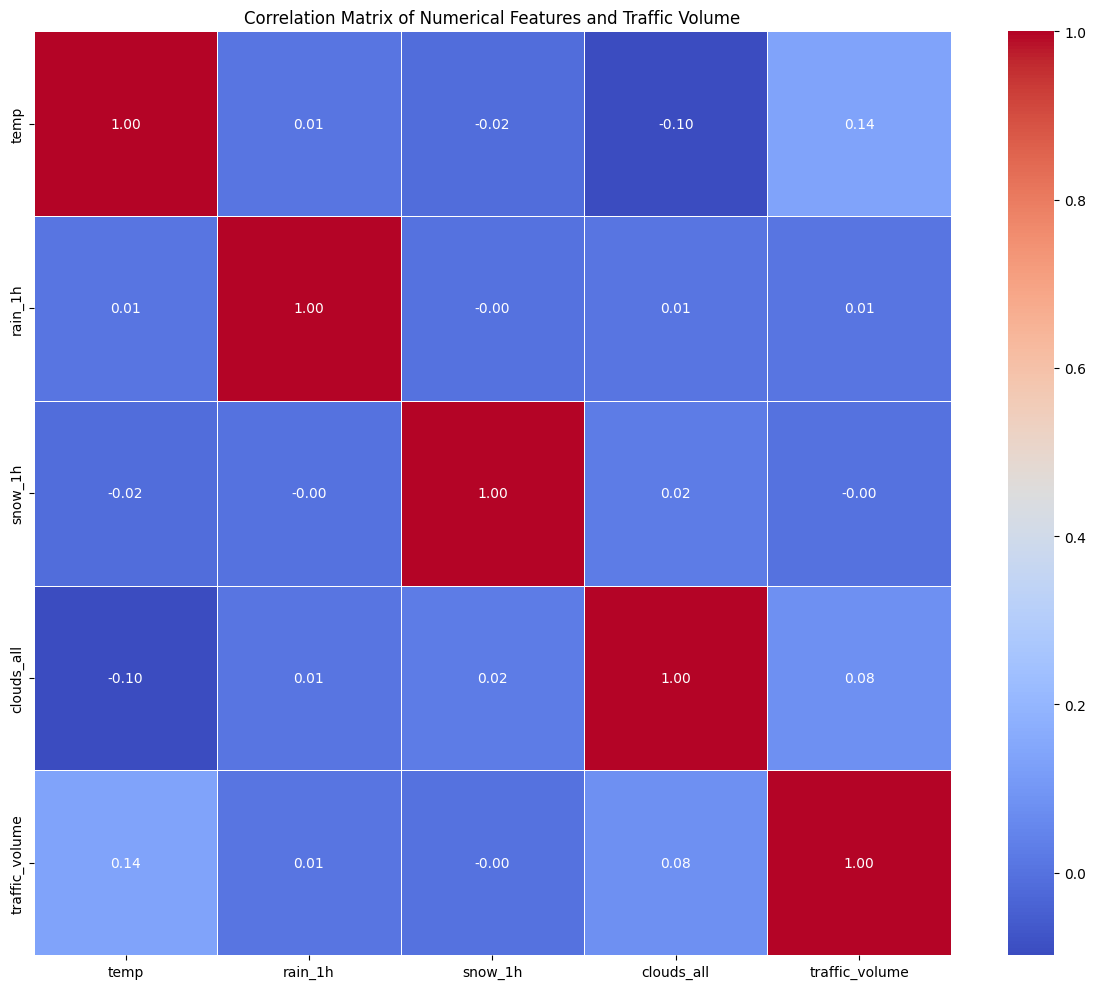

In [10]:
numerical_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all',  'traffic_volume']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Traffic Volume')
plt.tight_layout()
plt.show()

Dal grafico di correlazione possiamo affermare che nessuna delle colonne è fortemente correlata con la variabile di output traffic_volume e non si evidenzia nessun tipo di collinearità. Questo ci suggerisce che il volume di traffico dipende da altri fattori.

## Outlier Detection

Effettuiamo uno studio sulle variabili numeriche, per identificare eventuali outlier.

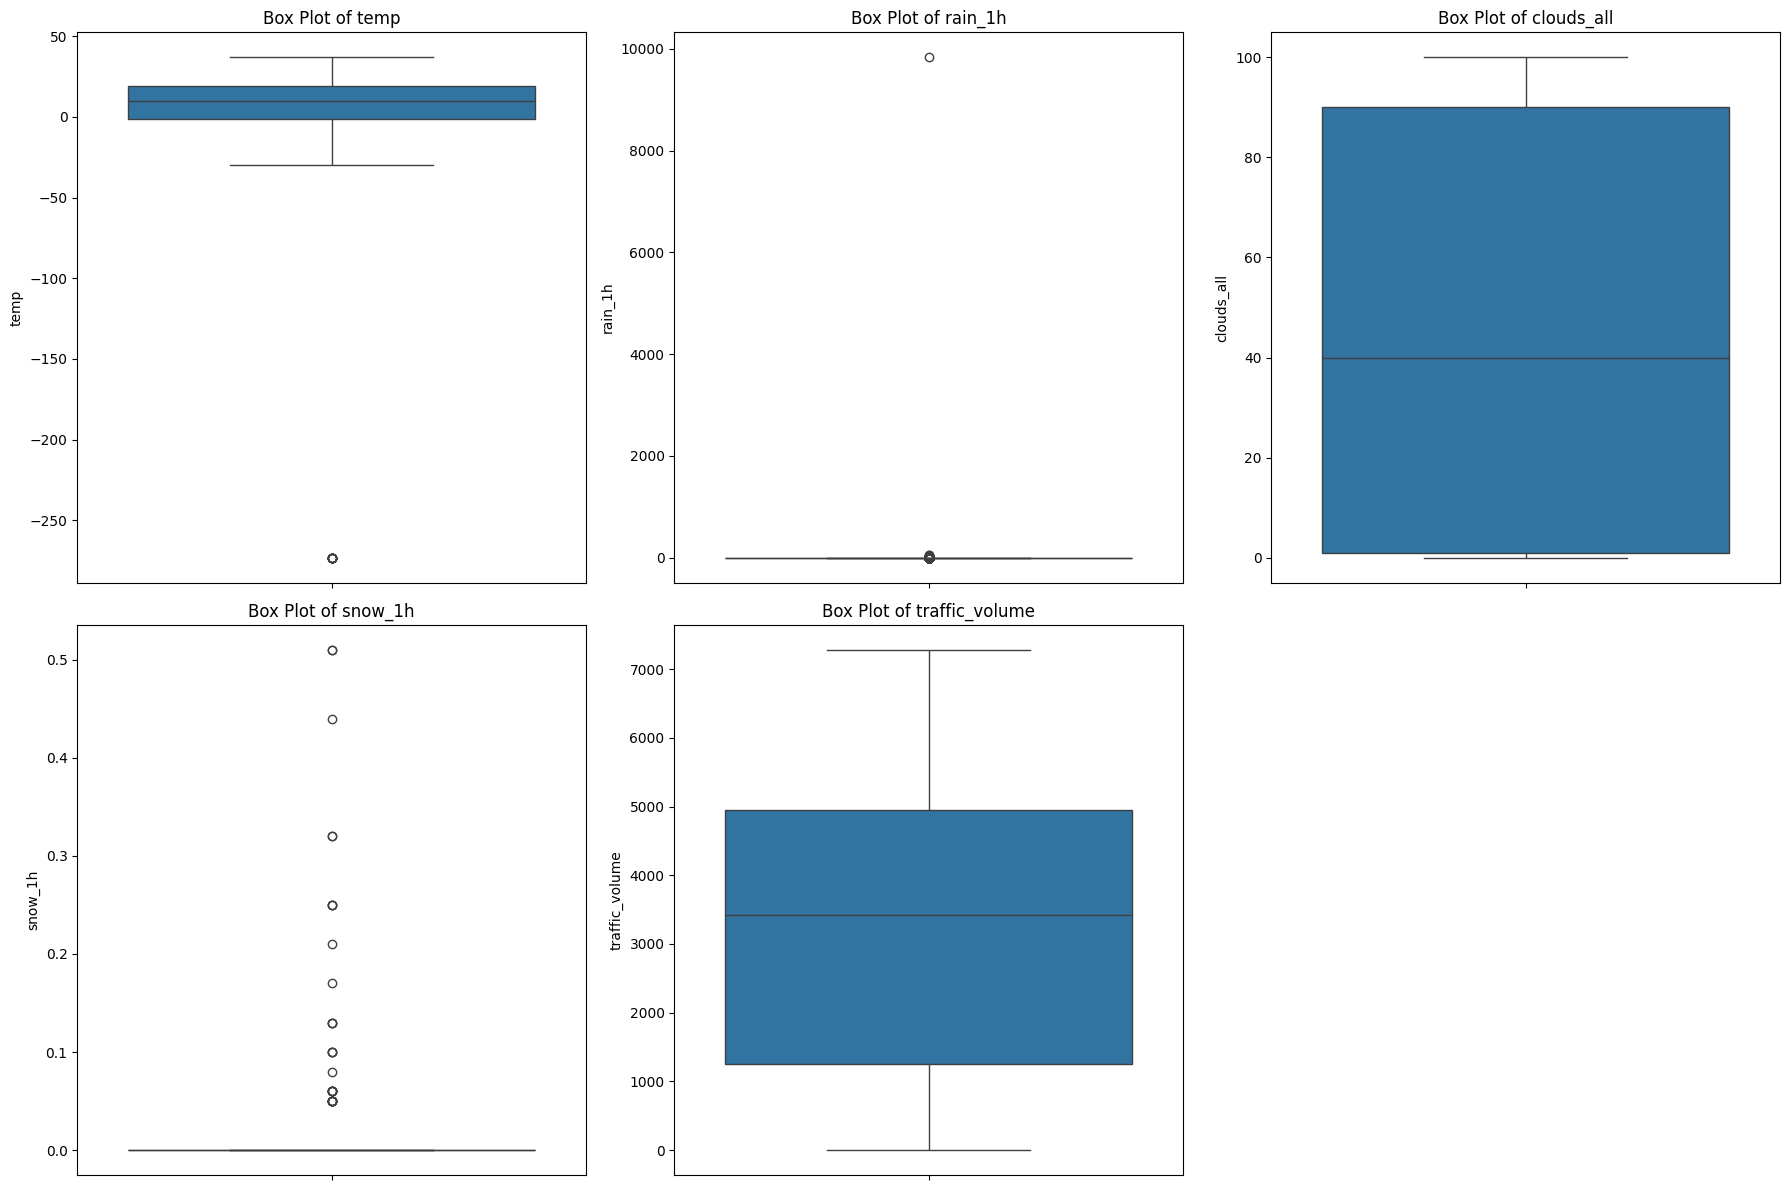

In [11]:
numerical_cols = ['temp', 'rain_1h', 'clouds_all', 'snow_1h', 'traffic_volume']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

Già dai Box Plot si evince una possibile presenza di outliers per quanto riguarda i campi "temp" e "rain_1h"

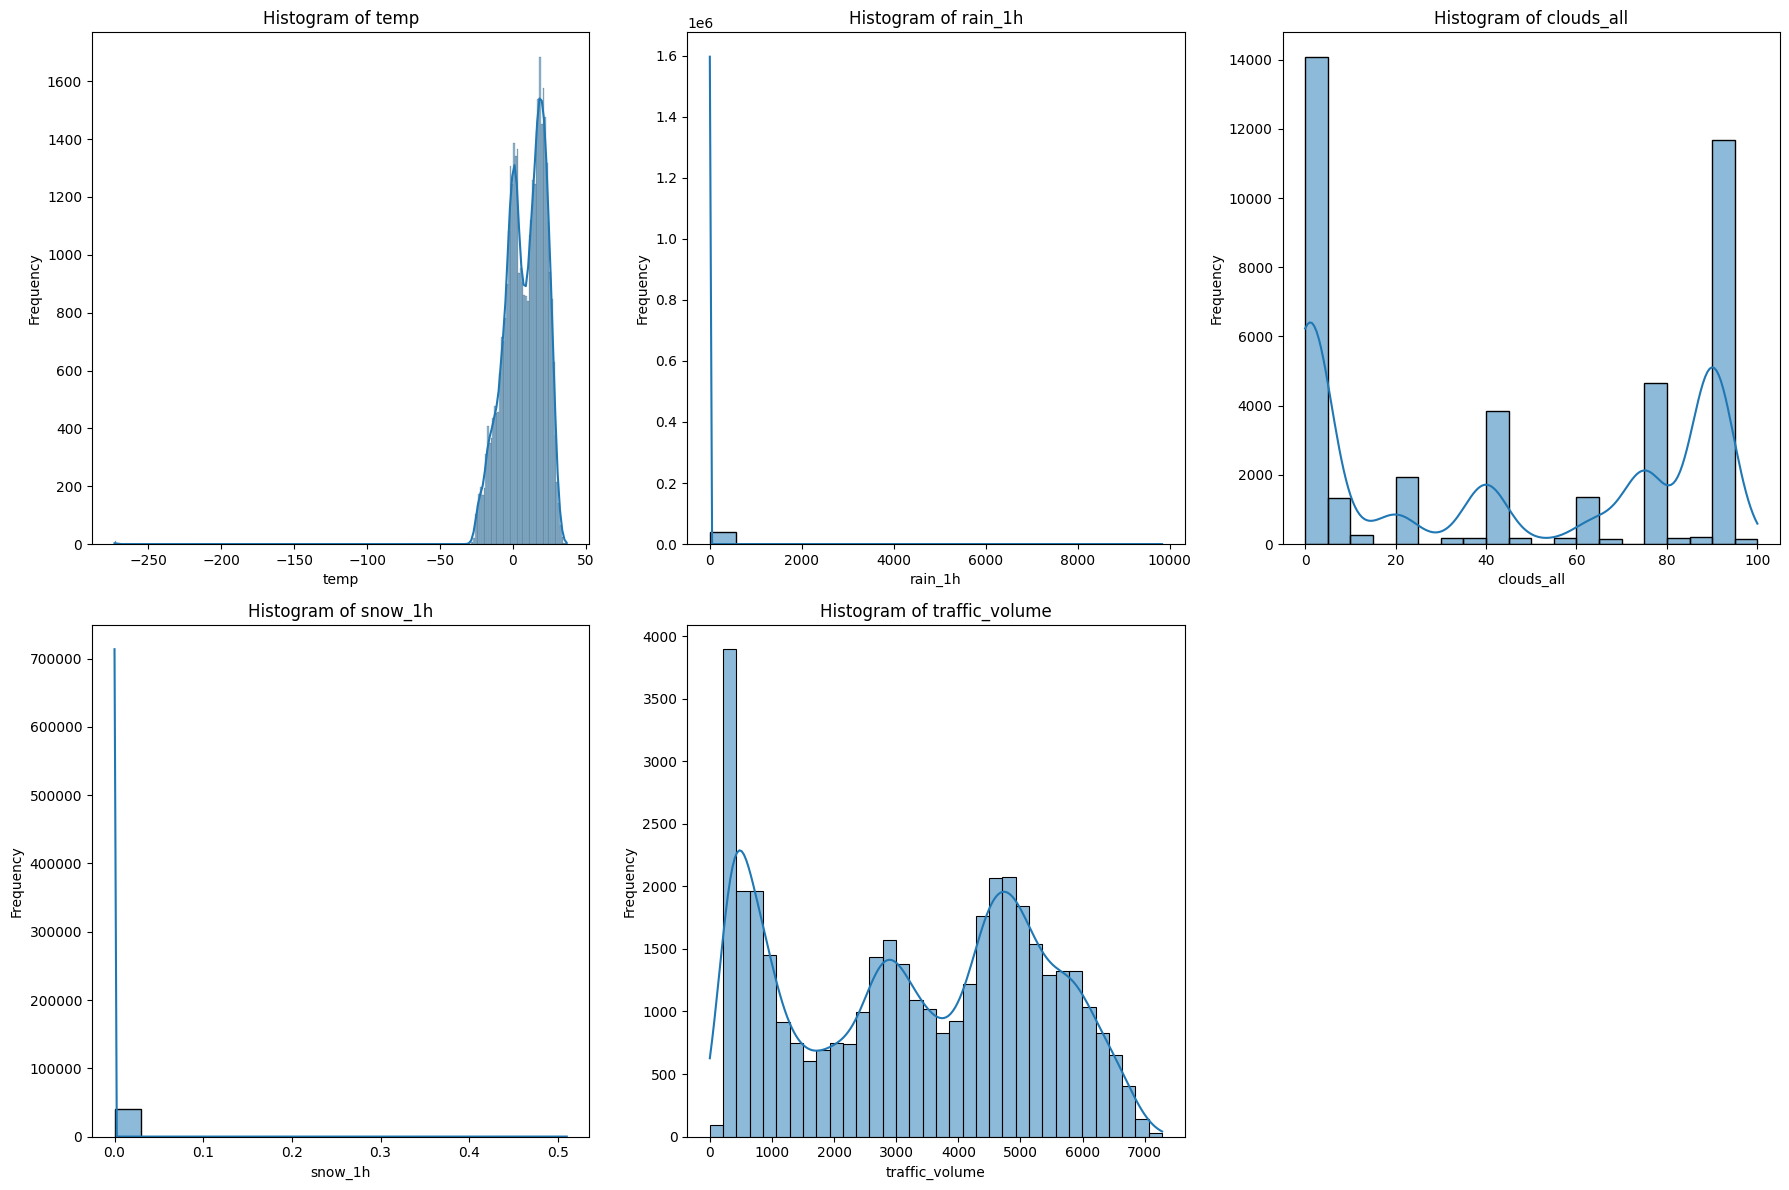

In [12]:
numerical_cols = ['temp', 'rain_1h', 'clouds_all', 'snow_1h', 'traffic_volume']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Per riassumere numericamente le distribuzioni e identificare i valori estremi per le colonne numeriche specificate, vengono calcolate e stampate le loro statistiche descrittive (media, mediana, minimo, massimo, deviazione standard, quartili) utilizzando il metodo `.describe()`.



In [13]:
numerical_cols = ['temp', 'rain_1h', 'snow_1h', 'traffic_volume']

print("\nDescriptive Statistics for Numerical Columns:")
print(df[numerical_cols].describe())


Descriptive Statistics for Numerical Columns:
               temp       rain_1h       snow_1h  traffic_volume
count  40575.000000  40575.000000  40575.000000    40575.000000
mean       8.165009      0.318619      0.000117     3290.650474
std       13.818404     48.812640      0.005676     1984.772909
min     -273.150000      0.000000      0.000000        0.000000
25%       -1.310000      0.000000      0.000000     1248.500000
50%        9.710000      0.000000      0.000000     3427.000000
75%       19.130000      0.000000      0.000000     4952.000000
max       36.920000   9831.300000      0.510000     7280.000000


Tra le variabili analizzate si evince che alcune possono essere escluse dall’analisi degli outlier:

- traffic_volume: la concentrazione di valori bassi (che si nota nell'istogramma) è fisiologica, poiché il traffico notturno è intrinsecamente ridotto; non si tratta quindi di anomalie.

- snow_1: i valori prossimi allo zero sono attesi, dato che le nevicate si verificano quasi esclusivamente durante i mesi invernali; anche in questo caso non sono outlier.

clouds_all: non mostra outliers

Tuttavia i rimanenti campi richiedono ulteriore analisi:
- **temp** ha valore minimo -273.15 C°
- **rain_1h** esprime un max pari a 9831

## Gestione degli Outliers

Per verificare se il valore minimo di temperatura di 0 K (-273,15 °C) sia un potenziale errore nei dati o un segnaposto valido, il DataFrame viene filtrato in modo da visualizzare tutte le righe in cui la colonna "temp" è uguale a -273,15.



In [14]:
print("Rows with temperature value of -273.15°C (0K):")
print(df[df['temp'] == -273.15])

Rows with temperature value of -273.15°C (0K):
                    holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2014-01-31 03:00:00    none -273.15      0.0      0.0           0   
2014-01-31 04:00:00    none -273.15      0.0      0.0           0   
2014-01-31 05:00:00    none -273.15      0.0      0.0           0   
2014-01-31 06:00:00    none -273.15      0.0      0.0           0   
2014-02-02 03:00:00    none -273.15      0.0      0.0           0   
2014-02-02 04:00:00    none -273.15      0.0      0.0           0   
2014-02-02 05:00:00    none -273.15      0.0      0.0           0   
2014-02-02 06:00:00    none -273.15      0.0      0.0           0   
2014-02-02 07:00:00    none -273.15      0.0      0.0           0   
2014-02-02 08:00:00    none -273.15      0.0      0.0           0   

                    weather_main weather_description  traffic_volume  
date_time                                            

Si identificano le precedenti 10 righe (0K) come errori di misurazione, tuttavia possiamo notare che tutte le righe incriminate fanno riferimento a due singoli giorni. Dunque è possibile andare a popolare i valori mancanti. Analizziamo i due giorni singolarmente.

In [15]:
print(df.loc["2014-01-31"][:10])

                    holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2014-01-31 00:00:00    none  -17.22      0.0      0.0           0   
2014-01-31 01:00:00    none  -17.22      0.0      0.0           0   
2014-01-31 02:00:00    none  -17.22      0.0      0.0           0   
2014-01-31 03:00:00    none -273.15      0.0      0.0           0   
2014-01-31 04:00:00    none -273.15      0.0      0.0           0   
2014-01-31 05:00:00    none -273.15      0.0      0.0           0   
2014-01-31 06:00:00    none -273.15      0.0      0.0           0   
2014-01-31 07:00:00    none  -17.22      0.0      0.0           0   
2014-01-31 08:00:00    none  -17.22      0.0      0.0           0   
2014-01-31 09:00:00    none  -17.22      0.0      0.0           0   

                    weather_main weather_description  traffic_volume  
date_time                                                             
2014-01-31 00:00:00        cl

In questo caso la temperatura si mantiene costante su  -17.22 C° dalle ore 00:00 alle ore 9:00, dunque possiamo riempire i campi errati con tale valore.

In [16]:
# Seleziona solo le righe del giorno 2014-01-31 e temp = -273.15
mask = (df.index.date == pd.to_datetime("2014-01-31").date()) & (df['temp'] == -273.15)

# Assegna il nuovo valore
df.loc[mask, 'temp'] = -17.22

# Controllo
print(df.loc["2014-01-31"].head(10))


                    holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-01-31 00:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 01:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 02:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 03:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 04:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 05:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 06:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 07:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 08:00:00    none -17.22      0.0      0.0           0        clear   
2014-01-31 09:00:00    none -17.22      0.0      0.0           0        clear   

                    weather

Analizziamo adesso le righe relative al secondo giorno

In [17]:
print(df.loc["2014-02-02"][:15])

                    holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2014-02-02 00:00:00    none  -17.56      0.0      0.0           0   
2014-02-02 01:00:00    none  -17.67      0.0      0.0           0   
2014-02-02 02:00:00    none  -17.78      0.0      0.0           0   
2014-02-02 03:00:00    none -273.15      0.0      0.0           0   
2014-02-02 04:00:00    none -273.15      0.0      0.0           0   
2014-02-02 05:00:00    none -273.15      0.0      0.0           0   
2014-02-02 06:00:00    none -273.15      0.0      0.0           0   
2014-02-02 07:00:00    none -273.15      0.0      0.0           0   
2014-02-02 08:00:00    none -273.15      0.0      0.0           0   
2014-02-02 09:00:00    none  -17.53      0.0      0.0           0   
2014-02-02 10:00:00    none  -16.11      0.0      0.0           0   
2014-02-02 11:00:00    none  -14.98      0.0      0.0           0   
2014-02-02 12:00:00    none  -12.7

C'è un aumento graduale nella temperatura per il giorno 2, quindi dobbiamo sostituire i valori errati allo stesso modo.

In [18]:
new_val = np.round(np.linspace(-17.78,-17.53,6,endpoint=False),2)
print(new_val)

[-17.78 -17.74 -17.7  -17.66 -17.61 -17.57]


In [19]:
# Seleziona solo le righe del giorno 2014-01-31 e temp = -273.15
mask = (df.index.date == pd.to_datetime("2014-02-02").date()) & (df['temp'] == -273.15)

print(mask[mask])

# Controllo della compatibilità
n_selected = mask.sum()
if n_selected == len(new_val):
  # Assegna i nuovi valori
  df.loc[mask, 'temp'] = new_val

  # Controllo
  print(df.loc["2014-02-02"].head(10))


date_time
2014-02-02 03:00:00    True
2014-02-02 04:00:00    True
2014-02-02 05:00:00    True
2014-02-02 06:00:00    True
2014-02-02 07:00:00    True
2014-02-02 08:00:00    True
Name: temp, dtype: bool
                    holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-02-02 00:00:00    none -17.56      0.0      0.0           0        clear   
2014-02-02 01:00:00    none -17.67      0.0      0.0           0        clear   
2014-02-02 02:00:00    none -17.78      0.0      0.0           0        clear   
2014-02-02 03:00:00    none -17.78      0.0      0.0           0        clear   
2014-02-02 04:00:00    none -17.74      0.0      0.0           0        clear   
2014-02-02 05:00:00    none -17.70      0.0      0.0           0        clear   
2014-02-02 06:00:00    none -17.66      0.0      0.0           0        clear   
2014-02-02 07:00:00    none -17.61      0.0      0.0           0     

Analizziamo dunque le righe con i valori di rain_1h più alti.

In [20]:
print("Top 10 rows ordered by 'rain_1h' in descending order:")
print(df.sort_values(by='rain_1h', ascending=False).head(10))

Top 10 rows ordered by 'rain_1h' in descending order:
                    holiday   temp  rain_1h  snow_1h  clouds_all  \
date_time                                                          
2016-07-11 17:00:00    none  28.96  9831.30      0.0          75   
2013-08-07 02:00:00    none  15.95    55.63      0.0          68   
2013-06-24 11:00:00    none  22.67    44.45      0.0          76   
2016-08-16 17:00:00    none  24.56    31.75      0.0           0   
2013-12-19 23:00:00    none  -8.65    28.70      0.0          64   
2015-07-13 00:00:00    none  18.87    27.57      0.0          90   
2015-08-16 21:00:00    none  21.34    25.46      0.0          90   
2013-07-14 06:00:00    none  19.50    25.32      0.0           8   
2015-07-06 03:00:00    none  21.72    23.80      0.0          90   
2013-07-14 07:00:00    none  19.72    21.42      0.0          90   

                     weather_main     weather_description  traffic_volume  
date_time                                            

Notiamo che c'è una sola riga con valore anomalo, dunque la eliminiamo.

In [21]:
df = df[df['rain_1h'] != 9831.30]
print("DataFrame after removing the row with the highest rain_1h value:")
print(df.sort_values(by='rain_1h', ascending=False).head())

DataFrame after removing the row with the highest rain_1h value:
                    holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2013-08-07 02:00:00    none  15.95    55.63      0.0          68         rain   
2013-06-24 11:00:00    none  22.67    44.45      0.0          76         rain   
2016-08-16 17:00:00    none  24.56    31.75      0.0           0         rain   
2013-12-19 23:00:00    none  -8.65    28.70      0.0          64         snow   
2015-07-13 00:00:00    none  18.87    27.57      0.0          90         mist   

                    weather_description  traffic_volume  
date_time                                                
2013-08-07 02:00:00     very heavy rain             315  
2013-06-24 11:00:00     very heavy rain            4802  
2016-08-16 17:00:00     very heavy rain            4913  
2013-12-19 23:00:00          light snow            1190  
2015-07-13 00:00:00

## Analisi dei Gap Temporali

Tracciamo il "traffic_volume" sull'intera serie temporale per verificare la presenza di gap "temporali"

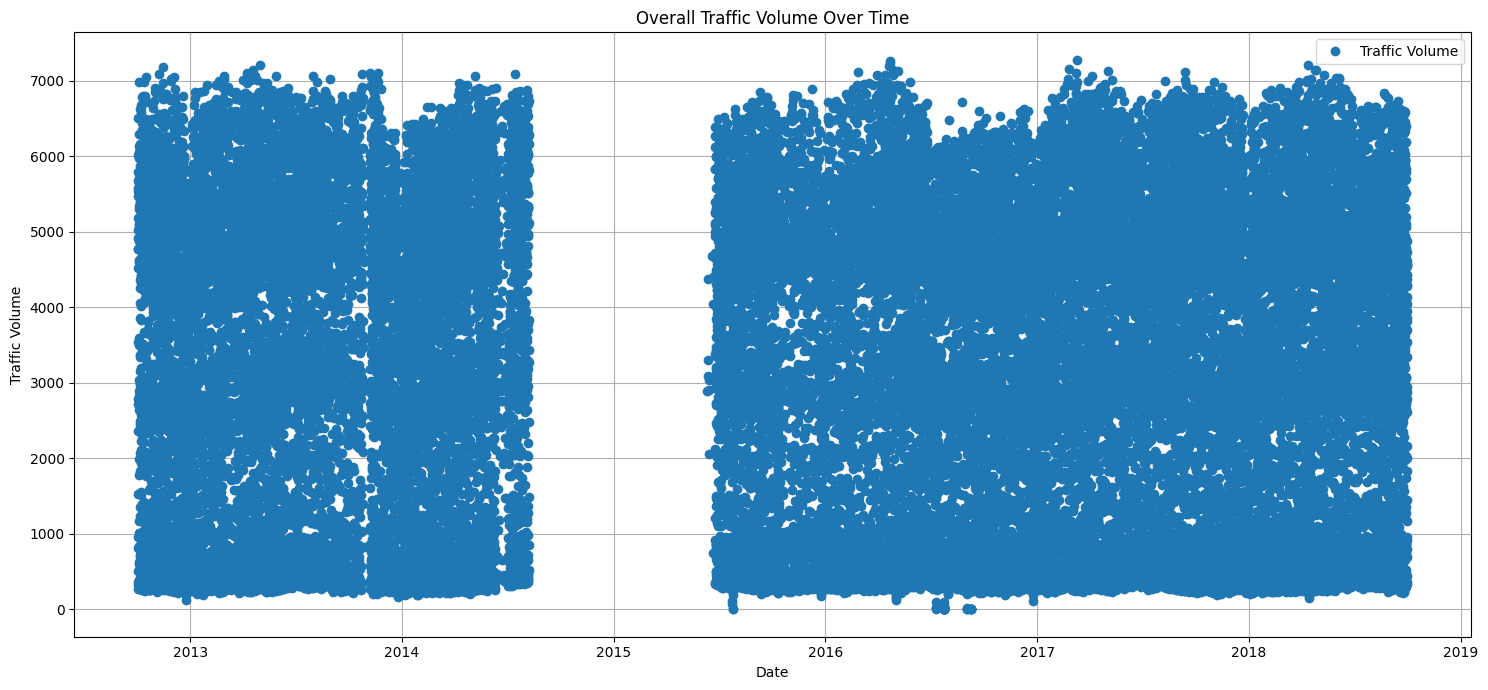

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['traffic_volume'], linestyle="none", marker='o', label='Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Overall Traffic Volume Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Notiamo subito la presenza di un **gap** temporale di circa 8 mesi, centrato nel Gennaio 2015. Valutiamo dunque analiticamente il fenomeno.

In [23]:
import pandas as pd

# Calcola le differenze tra timestamp consecutivi (esclude il primo NaT)
diffs = df.index.to_series().diff().dropna()

# Stima la frequenza "normale" come la mode delle differenze (fallback a 1H se non trovata)
expected = pd.to_timedelta(diffs.mode().iloc[0]) if not diffs.mode().empty else pd.Timedelta('1H')

# Identifica solo i salti maggiori della frequenza attesa
holes = diffs[diffs > expected]

# Precedente e successivo timestamp per ogni buco
prev_ts = holes.index - holes      # timestamp precedente al salto
next_ts = holes.index              # timestamp successivo al salto

# Inizio e fine del periodo MANCANTE (primo timestamp mancante, ultimo timestamp mancante)
missing_start = prev_ts + expected
missing_end = next_ts - expected

gap_info = pd.DataFrame({
    'prev_timestamp': prev_ts,
    'next_timestamp': next_ts,
    'missing_start': missing_start,
    'missing_end': missing_end,
    'gap_length': holes
}).reset_index(drop=True)

gap_info



,prev_timestamp,next_timestamp,missing_start,missing_end,gap_length
0,2012-10-03 06:00:00,2012-10-03 08:00:00,2012-10-03 07:00:00,2012-10-03 07:00:00,0 days 02:00:00
1,2012-10-03 09:00:00,2012-10-03 12:00:00,2012-10-03 10:00:00,2012-10-03 11:00:00,0 days 03:00:00
2,2012-10-03 16:00:00,2012-10-03 18:00:00,2012-10-03 17:00:00,2012-10-03 17:00:00,0 days 02:00:00
3,2012-10-05 01:00:00,2012-10-05 03:00:00,2012-10-05 02:00:00,2012-10-05 02:00:00,0 days 02:00:00
4,2012-10-05 03:00:00,2012-10-05 05:00:00,2012-10-05 04:00:00,2012-10-05 04:00:00,0 days 02:00:00
...,...,...,...,...,...
2584,2018-03-29 01:00:00,2018-03-29 03:00:00,2018-03-29 02:00:00,2018-03-29 02:00:00,0 days 02:00:00
2585,2018-05-05 01:00:00,2018-05-05 03:00:00,2018-05-05 02:00:00,2018-05-05 02:00:00,0 days 02:00:00
2586,2018-06-02 01:00:00,2018-06-02 03:00:00,2018-06-02 02:00:00,2018-06-02 02:00:00,0 days 02:00:00
2587,2018-08-07 06:00:00,2018-08-07 10:00:00,2018-08-07 07:00:00,2018-08-07 09:00:00,0 days 04:00:00


In [24]:
gap_info_sorted = gap_info.sort_values(by="gap_length", ascending=False)
gap_info_sorted


,prev_timestamp,next_timestamp,missing_start,missing_end,gap_length
895,2014-08-08 01:00:00,2015-06-11 20:00:00,2014-08-08 02:00:00,2015-06-11 19:00:00,307 days 19:00:00
663,2013-10-27 01:00:00,2013-11-06 04:00:00,2013-10-27 02:00:00,2013-11-06 03:00:00,10 days 03:00:00
901,2015-06-14 20:00:00,2015-06-19 18:00:00,2015-06-14 21:00:00,2015-06-19 17:00:00,4 days 22:00:00
782,2014-04-29 08:00:00,2014-05-04 05:00:00,2014-04-29 09:00:00,2014-05-04 04:00:00,4 days 21:00:00
1023,2015-10-23 11:00:00,2015-10-27 08:00:00,2015-10-23 12:00:00,2015-10-27 07:00:00,3 days 21:00:00
...,...,...,...,...,...
1055,2015-10-30 06:00:00,2015-10-30 08:00:00,2015-10-30 07:00:00,2015-10-30 07:00:00,0 days 02:00:00
1054,2015-10-30 04:00:00,2015-10-30 06:00:00,2015-10-30 05:00:00,2015-10-30 05:00:00,0 days 02:00:00
1053,2015-10-30 02:00:00,2015-10-30 04:00:00,2015-10-30 03:00:00,2015-10-30 03:00:00,0 days 02:00:00
1052,2015-10-30 00:00:00,2015-10-30 02:00:00,2015-10-30 01:00:00,2015-10-30 01:00:00,0 days 02:00:00


Ci accorgiamo dunque della presenza di ulteriori ~2500 gap nella nostra serie temporale, alcuni lunghi anche diversi giorni

## Analisi dei dati

### Analisi dell'andamento orario del volume di traffico

Estraiamo feature temporali quali ora, giorno della settimana, giorno dell'anno, mese, anno e un indicatore booleano per i fine settimana dall'indice "date_time".


In [25]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = (df.index.dayofweek == 5) | (df.index.dayofweek == 6) # Saturday (5) or Sunday (6)

print(df.head())

                    holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2012-10-02 09:00:00    none  15.13      0.0      0.0          40       clouds   
2012-10-02 10:00:00    none  16.21      0.0      0.0          75       clouds   
2012-10-02 11:00:00    none  16.43      0.0      0.0          90       clouds   
2012-10-02 12:00:00    none  16.98      0.0      0.0          90       clouds   
2012-10-02 13:00:00    none  17.99      0.0      0.0          75       clouds   

                    weather_description  traffic_volume  hour  day_of_week  \
date_time                                                                    
2012-10-02 09:00:00    scattered clouds            5545     9            1   
2012-10-02 10:00:00       broken clouds            4516    10            1   
2012-10-02 11:00:00     overcast clouds            4767    11            1   
2012-10-02 12:00:00     overcast clouds   

Analizziamo e visualizziamo i modelli di traffico giornalieri calcolando il `traffic_volume` medio per ogni ora, separando i giorni feriali dai fine settimana per comprendere la stagionalità giornaliera.

In [26]:
df_weekday = df[df['is_weekend'] == False]
df_weekend = df[df['is_weekend'] == True]

avg_traffic_weekday = df_weekday.groupby('hour')['traffic_volume'].mean()
avg_traffic_weekend = df_weekend.groupby('hour')['traffic_volume'].mean()

print("Average Traffic Volume by Hour (Weekdays):\n", avg_traffic_weekday)
print("\nAverage Traffic Volume by Hour (Weekends):\n", avg_traffic_weekend)

Average Traffic Volume by Hour (Weekdays):
 hour
0      655.215559
1      400.186161
2      303.099343
3      362.868003
4      830.107084
5     2699.254804
6     5375.273780
7     6061.162458
8     5508.896580
9     4900.601709
10    4400.511513
11    4663.444724
12    4873.933775
13    4879.508446
14    5182.139324
15    5629.210084
16    6240.881967
17    5823.123415
18    4485.019056
19    3332.081193
20    2877.224039
21    2701.767594
22    2149.272431
23    1404.371084
Name: traffic_volume, dtype: float64

Average Traffic Volume by Hour (Weekends):
 hour
0     1323.411043
1      817.800403
2      620.313152
3      399.438559
4      381.582822
5      642.768443
6     1103.097046
7     1600.200413
8     2353.924490
9     3132.916844
10    3718.390593
11    4081.983087
12    4402.638430
13    4407.611452
14    4392.836777
15    4372.389006
16    4375.213552
17    4186.441667
18    3852.757895
19    3257.619748
20    2850.779835
21    2693.259336
22    2411.294118
23    1707.866667


Plottiamo l'andamento del TrafficVolume durante le ore del giorno, separatamente per giorni feriali e weekend.

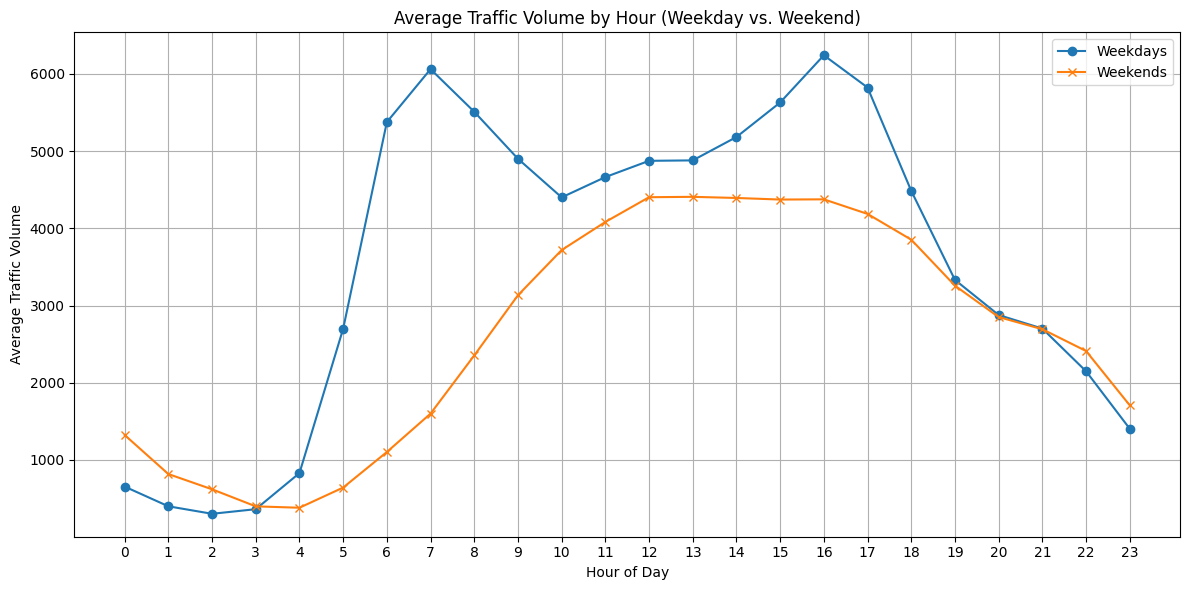

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(avg_traffic_weekday.index, avg_traffic_weekday.values, label='Weekdays', marker='o')
plt.plot(avg_traffic_weekend.index, avg_traffic_weekend.values, label='Weekends', marker='x')

plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Hour (Weekday vs. Weekend)')
plt.xticks(range(0, 24)) # Ensure all hours are displayed on the x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Notiamo dunque come sia possibile identificare dei trend che si ripetono potenzialmente ogni giorno, come i picchi nei giorni lavorativi nelle ore di entrata/uscita degli uffici. Questo ci suggerisce di utilizzare una lag feature che faccia riferimento al volume di traffico di 24h prima.

### Analizza i modelli di traffico settimanali

In [28]:
avg_traffic_day_of_week = df.groupby('day_of_week')['traffic_volume'].mean()  # 0=Monday, 6=Sunday

print("Average Traffic Volume by Day of Week:\n", avg_traffic_day_of_week)

Average Traffic Volume by Day of Week:
 day_of_week
0    3313.177475
1    3534.717166
2    3608.276064
3    3653.914611
4    3674.777608
5    2822.564661
6    2426.249484
Name: traffic_volume, dtype: float64


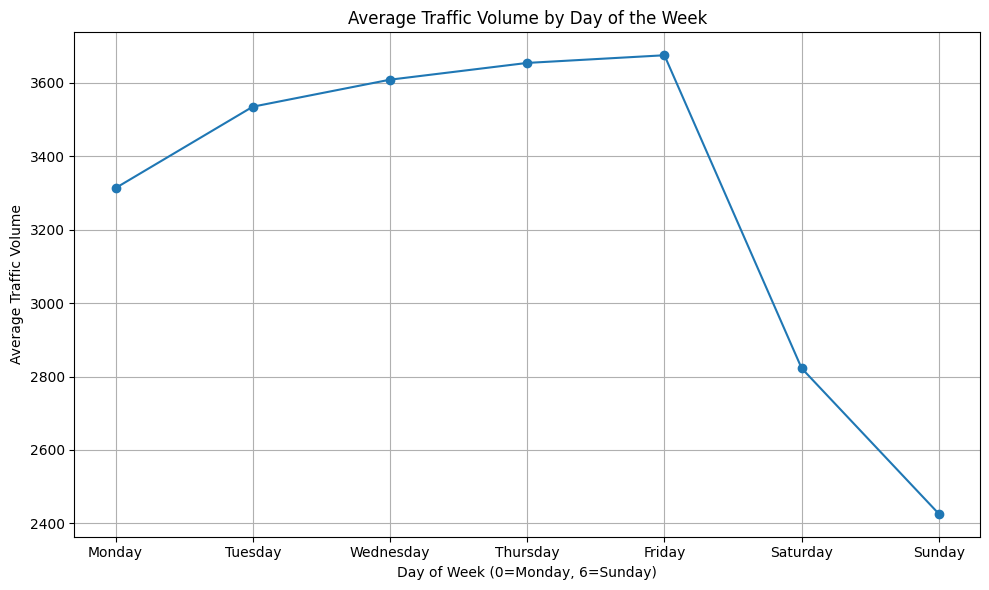

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(avg_traffic_day_of_week.index, avg_traffic_day_of_week.values, marker='o')

plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.tight_layout()
plt.show()

Notiamo come il volume di traffico sia soggetto a un calo prevedibile e ricorrente ogni fine settimana, mostrando una forte Stagionalità Settimanale. Per sfruttare questo pattern cruciale e robusto, è essenziale introdurre una lag_168 feature (il volume di traffico di 7 giorni prima), che permette al modello di confrontare ogni giorno feriale/weekend con la sua controparte della settimana precedente

### Analizza i modelli di traffico mensili


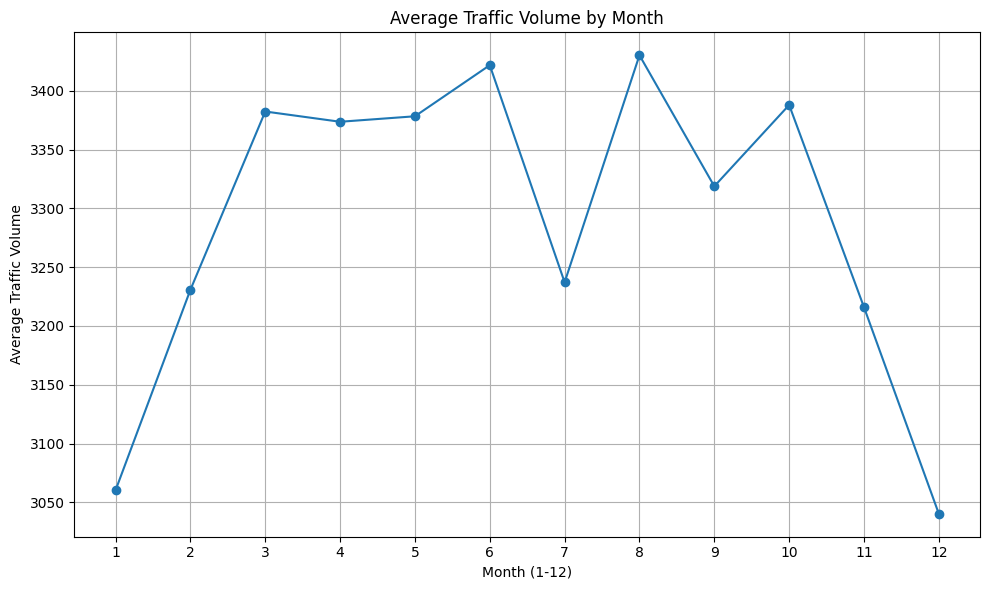

Average Traffic Volume by Month:
 month
1    3060.224270
2    3230.793492
3    3382.463363
4    3373.742464
5    3378.407151
Name: traffic_volume, dtype: float64


In [30]:
avg_traffic_month = df.groupby('month')['traffic_volume'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_traffic_month.index, avg_traffic_month.values, marker='o')
plt.xlabel('Month (1-12)')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average Traffic Volume by Month:\n", avg_traffic_month.head())


Notiamo come il volume di traffico mostri una chiara variazione in base al mese e alle stagioni (es. calo marcato tra Dicembre e Gennaio), evidenziando una Stagionalità Annuale. Per sfruttare questo pattern a lungo termine, si può ricorrere a :

- Lag Feature lag_8760: Introdurre una lag_8760 feature (volume di traffico di 12 mesi/1 anno prima) per permettere al modello di confrontare il traffico del campione attuale con il suo precedente ciclo annuale, un predittore robusto per la previsione a lungo raggio.

Osservazione: abbiamo notato che l'utilizzo della lag feature relativa all'anno precedente ci avrebbe portato a rimuovere circa 15k righe (tutto il primo anno, tutto l'anno successivo al gap principale, tutte le righe che precedono di un anno il resto dei gap).
Si è deciso quindi di non ricorrere a questa feature

## Lag Features

L'introduzione delle Lag Features serve a codificare la memoria storica del traffico per il modello di regressione.

- df.asfreq('H'): Assicura l'allineamento orario preciso.

- lag_1: Cattura l'Inerzia (traffico dell'ora precedente).

- lag_24, lag_168 : Catturano la Stagionalità Giornaliera, Settimanale.

- df.dropna(...): Rimuove le righe incomplete (i gap e l'inizio della serie) generate dai ritardi.

Viene realizzato un primo tentativo sul dataset "bucato" per valutare analiticamente l'effettiva perdita di righe dovute all'introduzione delle lag feature. In caso di perdite sostanziose si valuta l'imputazione dei dati mancanti.

In [31]:
print(df.shape)

(40574, 14)


In [32]:
df = df.asfreq('H')  # crea righe vuote per i gap
df['lag_1'] = df['traffic_volume'].shift(1)
df['lag_24'] = df['traffic_volume'].shift(24)
df['lag_168'] = df['traffic_volume'].shift(168)
#df['lag_8760'] = df['traffic_volume'].shift(8760)
df = df.dropna(subset=['traffic_volume', 'lag_1', 'lag_24', 'lag_168'])


In [33]:
print(df.shape)

(34728, 17)


Si è deciso di non imputare le righe relative ai gap per evitare di introdurre dati artificiali. Infatti, abbiamo valutato che la perdita di ~6k righe, dovuta all’introduzione delle lag features, resta accettabile rispetto al rischio di distorcere trend e pattern della serie temporale.

## Correlation Plot n.2


Dopo aver aggiunto le variabili temporali e i lag si ripete l'analisi di correlazione.

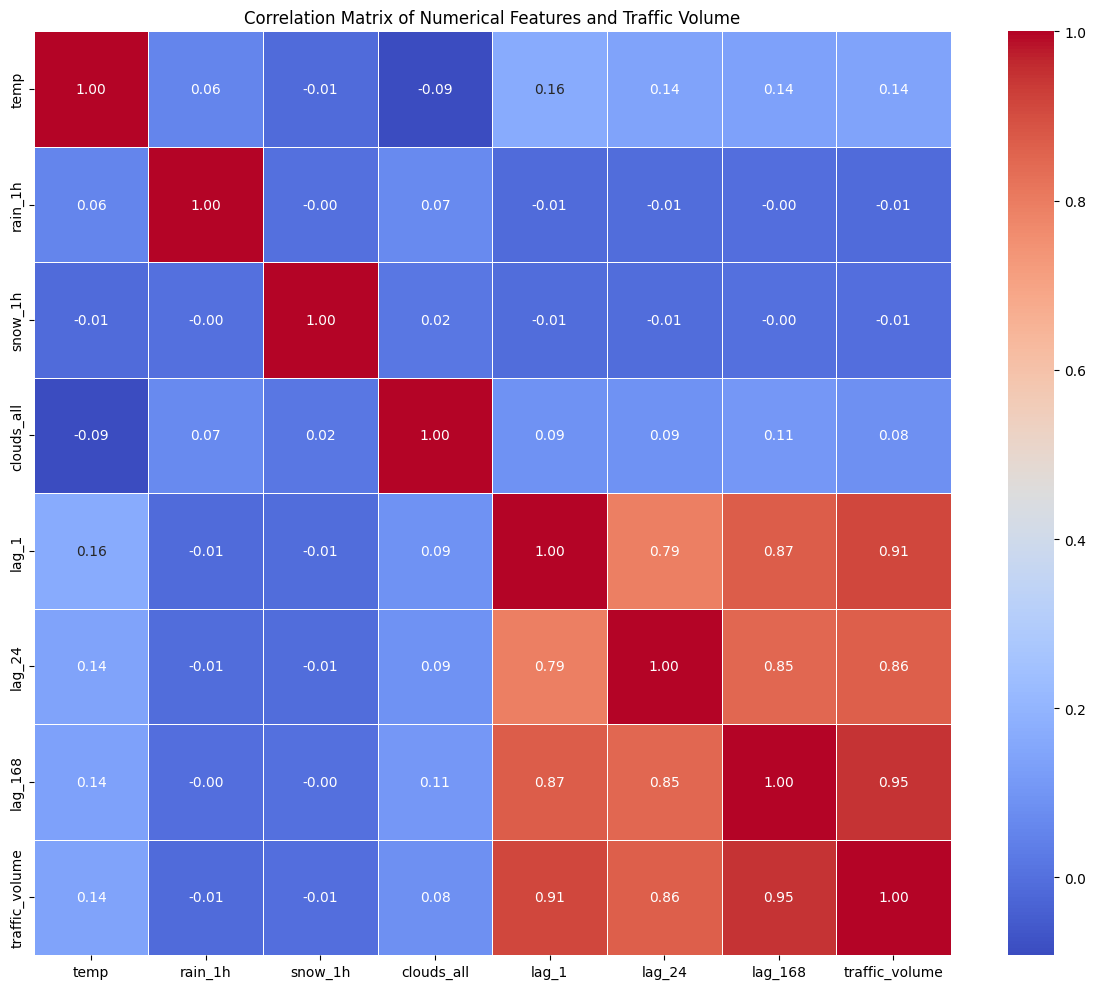

In [35]:
#numerical_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour' , 'day_of_week', 'day_of_year', 'month', 'year' , 'is_weekend', 'lag_1', 'lag_24' ,'traffic_volume']
#correlation_matrix = df[numerical_features].corr()

corr_features = [
    'temp', 'rain_1h', 'snow_1h', 'clouds_all',
    'lag_1', 'lag_24', 'lag_168', 'traffic_volume'
]

correlation_matrix = df[corr_features].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Traffic Volume')
plt.tight_layout()
plt.show()

L'analisi di correlazione conferma che la varianza del traffico è dominata dai fattori temporali e dai lag (con correlazioni superiori a +0.86), mentre le condizioni ambientali sono deboli predittori.

Si tiene conto di questo problema nella scelta del modello di regressione

## Analisi delle proprietà della serie temporale

Si effettuano i test ADF e ACF/PACF per valutare la stazionarietà, comprendere le dipendenze passate (autocorrelazione) e identificare i pattern ciclici intrinseci alla serie temporale, informazioni cruciali per la scelta e l'interpretazione dei modelli predittivi.

### ADF Test

Verifichiamo la stazionarietà della serie temporale mediante l’Augmented Dickey–Fuller test, che consente di testare l’ipotesi nulla di presenza di una radice unitaria. L’assenza di una radice unitaria è una condizione necessaria per la stazionarietà della serie.

In [36]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np

def dataset_statistics(df, target_column='traffic_volume'):
    """
    Esegue il Test di Dickey-Fuller Aumentato (ADF) solo sulla variabile target
    specificata (traffic_volume) per verificare la stazionarietà.

    Args:
        df (pd.DataFrame): Il DataFrame contenente la serie temporale.
        target_column (str): Il nome della colonna target su cui eseguire il test ADF.

    Returns:
        pd.DataFrame: Un DataFrame contenente l'ADF Statistic e il p-value per il target.
    """

    # 1. Verifica che la colonna target esista
    if target_column not in df.columns:
        raise ValueError(f"La colonna '{target_column}' non è presente nel DataFrame.")

    # 2. Seleziona la serie temporale e rimuovi eventuali NaN
    ts = df[target_column].dropna()

    # 3. Esegui il Test ADF
    try:
        # adfuller restituisce: (Statistica ADF, p-value, Lag usati, Numero Osservazioni, Valori critici, icbest)
        adf_test = adfuller(ts)

        adf_results = {
            'ADF Statistic': adf_test[0],
            'p-value': adf_test[1],
            'Lags Used': adf_test[2],
            'Number of Observations': adf_test[3],
            'Critical Value (1%)': adf_test[4]['1%'],
            'Critical Value (5%)': adf_test[4]['5%'],
            'Critical Value (10%)': adf_test[4]['10%'],
            'Risultato': 'Stazionario' if adf_test[1] <= 0.05 else 'Non Stazionario'
        }

    except ValueError as e:
        print(f"Errore durante l'esecuzione del test ADF sulla colonna {target_column}: {e}")
        return pd.DataFrame()

    # 4. Crea un DataFrame di output più leggibile
    adf_df = pd.DataFrame(adf_results, index=[target_column]).T

    return adf_df

adf_df = dataset_statistics(df)
print(adf_df)

                       traffic_volume
ADF Statistic              -24.632741
p-value                           0.0
Lags Used                          52
Number of Observations          34675
Critical Value (1%)         -3.430539
Critical Value (5%)         -2.861623
Critical Value (10%)        -2.566814
Risultato                 Stazionario


Il Test ADF sul target (traffic_volume) ha fornito i seguenti risultati:

- ADF Statistic (-24.6): Estremamente basso, ben al di sotto dei valori critici.

- p-value (0.0): Rifiutiamo l'ipotesi nulla.

- Lags Used (52): Conferma una complessa dipendenza (memoria) della serie fino a 51 ore.

Conclusione: La serie è statisticamente stazionaria. Questo permette di procedere all'addestramento dei modelli di Regressione Lineare e ad Albero direttamente sul set di dati attuale, senza la necessità di applicare la Differenziazione.

## ACF e PACF Test

Generazione del grafico ACF (Autocorrelazione)...


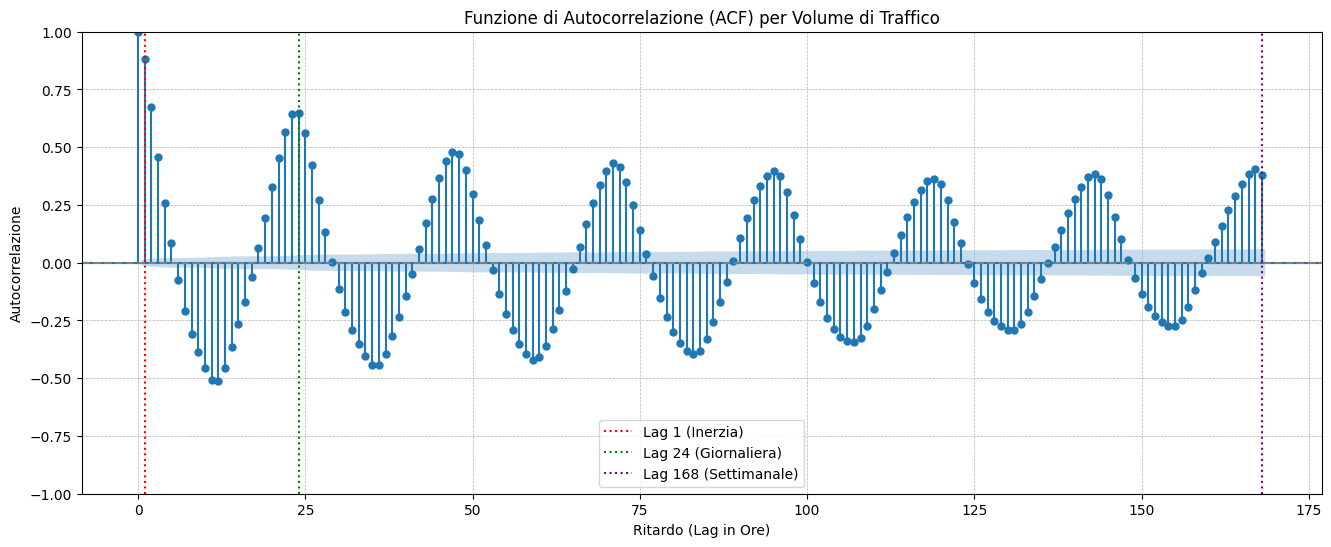


Interpretazione: La ACF mostra la correlazione totale, che decade lentamente a causa della stagionalità e dell'inerzia.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

# 1. Preparazione della Serie
# Utilizziamo la serie 'traffic_volume' pulita e senza NaN, come per la PACF
ts_acf = df['traffic_volume'].dropna()

# 2. Impostazioni Grafiche
# Manteniamo la stessa dimensione per confrontare ACF e PACF
plt.rcParams.update({'figure.figsize': (16, 6)})

# 3. Generazione del Grafico ACF
# Lags: Visualizziamo 168 lag per catturare la stagionalità settimanale.
print("Generazione del grafico ACF (Autocorrelazione)...")

# Utilizziamo 'plot_acf' per la funzione
plot_acf(
    ts_acf,
    lags=168,
    title='Funzione di Autocorrelazione (ACF) per Volume di Traffico'
)

# 4. Aggiunta di Annotazioni e Visualizzazione
plt.axhline(0, linestyle='--', color='gray')

# Aggiungiamo linee verticali per i lag cruciali:
plt.axvline(1, color='red', linestyle=':', linewidth=1.5, label='Lag 1 (Inerzia)')
plt.axvline(24, color='green', linestyle=':', linewidth=1.5, label='Lag 24 (Giornaliera)')
plt.axvline(168, color='purple', linestyle=':', linewidth=1.5, label='Lag 168 (Settimanale)')

plt.xlabel('Ritardo (Lag in Ore)')
plt.ylabel('Autocorrelazione')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


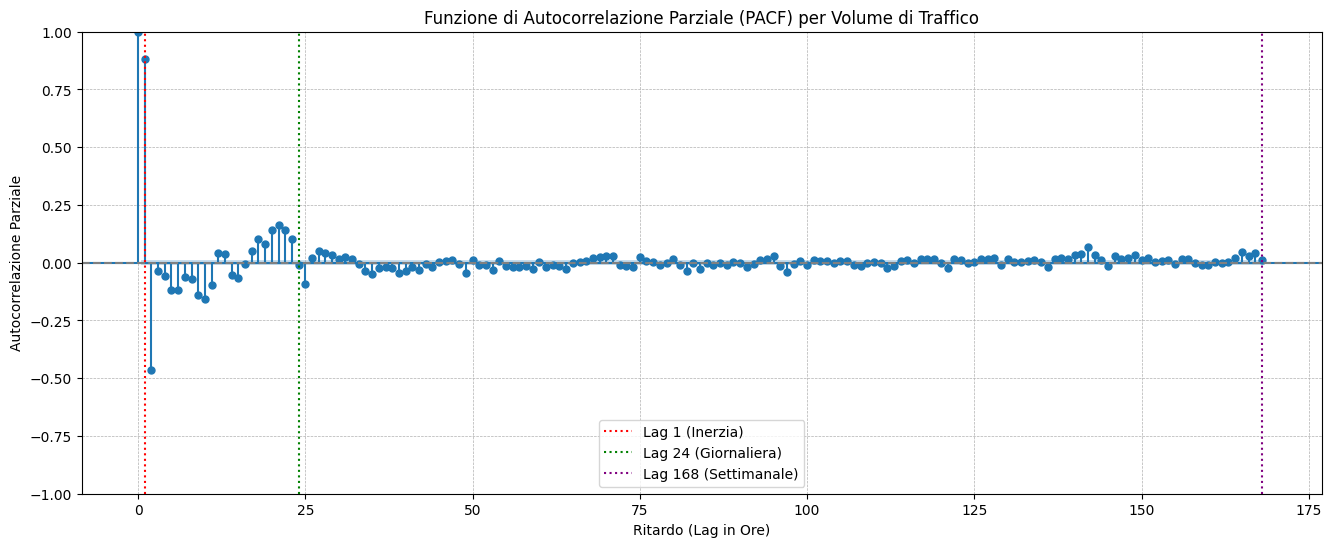


Interpretazione: I picchi che escono dalla banda blu (area di confidenza) indicano i lag che sono predittori diretti della serie.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf

# 1. Preparazione della Serie
ts_pacf = df['traffic_volume']

# 2. Impostazioni Grafiche
plt.rcParams.update({'figure.figsize': (16, 6)})

# 3. Generazione del Grafico PACF


# Utilizziamo 'pacf' per la funzione
plot_pacf(
    ts_pacf,
    lags=168,
    title='Funzione di Autocorrelazione Parziale (PACF) per Volume di Traffico'
)

# 4. Aggiunta di Annotazioni e Visualizzazione
plt.axhline(0, linestyle='--', color='gray')

# Aggiungiamo linee verticali per i lag cruciali che ci aspettiamo di vedere:
plt.axvline(1, color='red', linestyle=':', linewidth=1.5, label='Lag 1 (Inerzia)')
plt.axvline(24, color='green', linestyle=':', linewidth=1.5, label='Lag 24 (Giornaliera)')
plt.axvline(168, color='purple', linestyle=':', linewidth=1.5, label='Lag 168 (Settimanale)')

plt.xlabel('Ritardo (Lag in Ore)')
plt.ylabel('Autocorrelazione Parziale')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print("\nInterpretazione: I picchi che escono dalla banda blu (area di confidenza) indicano i lag che sono predittori diretti della serie.")

I grafici ACF e PACF convalidano la struttura di memoria della serie temporale del traffic_volume.

- ACF (Totale): Mostra una forte e lenta stagionalità con picchi chiari in corrispondenza dei multipli di 24 ore e al Lag 168, confermando che il traffico è un processo altamente ciclico e prevedibile .

- PACF (Diretta): Il grafico PACF conferma il Lag 1 come predittore dominante (Inerzia Oraria).
 Sebbene il segnale di autocorrelazione parziale (diretta) ai Lag 24 e Lag 168 sia contenuto (piccoli picchi che superano la banda di confidenza), si è scelto di includerli per motivi di domini:
  - Lag 24 (Ciclo Giornaliero): Cattura l'effetto diretto della routine pendolare (es. l'ora di punta del giorno precedente) e non è sostituibile da altri lag.
  - Lag 168 (Ciclo Settimanale): È fondamentale per distinguere i giorni feriali dal weekend

## Salvataggio dati puliti

In fine si salvano i dati "puliti" per gli scopi successivi.

In [ ]:
#Tronca la temperatura a due cifre decimali
df['temp'] = df['temp'].apply(lambda x: np.floor(x * 100) / 100)


# Sposta traffico alla fine
col = 'traffic_volume'
cols = [c for c in df.columns if c != col] + [col]
df = df[cols]

print(df)

                    holiday   temp  rain_1h  snow_1h  clouds_all  \
date_time                                                          
2012-10-09 09:00:00    none   6.20      0.0      0.0        90.0   
2012-10-09 10:00:00    none   8.22      0.0      0.0        90.0   
2012-10-09 11:00:00    none   9.96      0.0      0.0        90.0   
2012-10-09 12:00:00    none  10.93      0.0      0.0        75.0   
2012-10-09 13:00:00    none  11.99      0.0      0.0        75.0   
...                     ...    ...      ...      ...         ...   
2018-09-30 19:00:00    none  10.30      0.0      0.0        75.0   
2018-09-30 20:00:00    none   9.61      0.0      0.0        90.0   
2018-09-30 21:00:00    none   9.58      0.0      0.0        90.0   
2018-09-30 22:00:00    none   8.93      0.0      0.0        90.0   
2018-09-30 23:00:00    none   8.97      0.0      0.0        90.0   

                     weather_main     weather_description  hour  day_of_week  \
date_time                          

In [ ]:
df.to_csv('/content/drive/MyDrive/Datasets/cleaned_data_with_datetime.csv',header=True,index=True)

df.to_csv('/content/drive/MyDrive/Datasets/cleaned_data.csv',header=True,index=False)